# Coadded spectrum

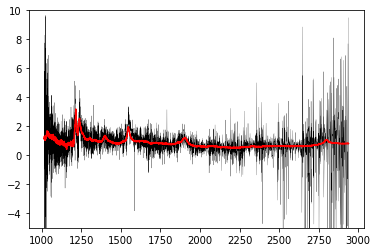

In [1]:
import astropy.io.fits as fits
import numpy as np
import os
import matplotlib.pyplot as plt
import astropy.constants as const


data_path = './spec_data/data/7098/'
spec_list = os.listdir(data_path)

spec_name = data_path + spec_list[0]
spec = fits.open(spec_name)


flux = spec[1].data['flux']
loglam = spec[1].data['loglam']
lam = 10**(loglam)
model = spec[1].data['model']
z = spec[2].data['z']
lrf = lam/(1+z)

scp = ((lrf<1180)&(lrf>1050))

plt.plot(lrf[:],flux[:],lw=0.2,c='k')
plt.plot(lrf[:],model[:],c='r')
plt.ylim(-5,10)


vel = loglam[scp]*np.log(10.)*const.c.to('km/s')


# semi-difference $\Delta \phi$

$\Delta \phi$ = spec_even - spec_odd (?)

$\alpha = 4\times[N_{\rm{exp}}]\times[(N_{\rm{exp}}+1)/2]/N_{\rm{exp}}^2$

$P_{\rm{diff}}^{noise}(k) = |F(\alpha\Delta \phi)|^2$



In [2]:
odd = {'wflux':[],'ivar':[]}
even = {'wflux':[],'ivar':[]}

from scipy.interpolate import interp1d

loglam_new = np.linspace(3.767,3.799,2000)
Nexp = len(spec)-5
alpha = 4*(Nexp/2)*((Nexp+1)/2)/Nexp**2

for i in np.arange(5,len(spec)):
    if i%2 == 0: #even
        loglam = spec[i].data['loglam']
        flux = spec[i].data['flux']
        mask = spec[i].data['mask']
        ivar = spec[i].data['ivar']        
        wflux = flux*ivar
        interp = interp1d(loglam,wflux,kind='nearest')
        wflux_new = interp(loglam_new)
        even['ivar'].append(ivar)
        even['wflux'].append(wflux_new)
        
    if i%2 == 1: #odd
        loglam = spec[i].data['loglam']
        flux = spec[i].data['flux']
        mask = spec[i].data['mask']
        ivar = spec[i].data['ivar']
        wflux = flux*ivar
        interp = interp1d(loglam,wflux,kind='nearest')
        wflux_new = interp(loglam_new)
        odd['ivar'].append(ivar)
        odd['wflux'].append(wflux_new)

avg_odd = np.mean(odd['wflux'],axis=0)
avg_even = np.mean(even['wflux'],axis=0)
semi = avg_even-avg_odd
asemi = alpha*semi

In [3]:
import pyfftw as fftw

Delta_vel = 69.029764
fft = fftw.builders.rfft(asemi)
pn = fft()
kk = 2*np.pi*np.fft.rfftfreq(len(loglam_new))/Delta_vel

/home/littlelin/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


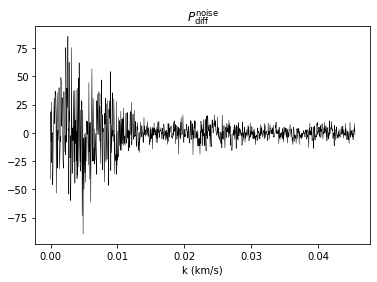

In [6]:
plt.plot(kk,pn,lw=0.5,c='k')
plt.xlabel('k (km/s)')
plt.title(r'$P^{\rm{noise}}_{\rm{diff}}$')
plt.show()